# Demo de implementación de un Algoritmo Genético para resolver el Problema del Vendedor Viajero (o TSP) y encontrar el mejor camino para unir varios puntos
Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

In [ ]:
#@title Instalar librerías
!pip install deap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.1 MB/s eta 0:00:00


In [ ]:
#@title Cargar Librerías
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from __future__ import division
import numpy as np
from scipy import spatial
import matplotlib as mpl
from matplotlib import cm
import copy

import math
from deap import base
from deap import creator
from deap import tools

import matplotlib
import matplotlib.pyplot as plt
import networkx
from IPython.display import display
from PIL import Image

print("\nLibrerías importadas")


Librerías importadas


In [ ]:
#@title PARÁMETROS

#@markdown Parámetros del AG:

# Cantidad de Ciclos de la Corrida
CANT_CICLOS =   50#@param {type:"integer"}

# Indica que finaliza corrida cuando se alcance una  Aptitud Mínima (opcional)
FINALIZA_CORRIDA_POR_APTITUD = True  #@param {type:"boolean"}

# Cantidad de Individuos en la Población
CANT_INDIVIDUOS_POBLACION = 15 #@param {type:"integer"}
if CANT_INDIVIDUOS_POBLACION < 5:
  CANT_INDIVIDUOS_POBLACION = 5


#@markdown Parámetros del Espacio de búsqueda para TSP:

CANT_POSICIONES = 10 #@param {type:"slider", min:3, max:25, step:1}
if CANT_POSICIONES < 3:
  CANT_POSICIONES = 3

MIN_ESPACIO_BUSQ = 0 #@param {type:"slider", min:-100, max:0, step:5}
MAX_ESPACIO_BUSQ = 100  #@param {type:"slider", min:0, max:100, step:5}


print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


3) Inicializar objetos de DEAP para utilizar y especificar Mapa de Búsqueda:

In [ ]:
posDefinidas = []
defPosicionesManual = True #@param {type:"boolean"}
#@markdown Nota: si no marca esta opción el grafo se genera en forma aleatoria.

if defPosicionesManual:
  # indicar las posiciones (x, y)
  # que corresponden
  # a cada uno de los puntos a unir
  posDefinidas.append( [1, 1])
  posDefinidas.append( [100, 1])
  posDefinidas.append( [1, 100])
  posDefinidas.append( [100, 100])
  posDefinidas.append( [50, 50])
  posDefinidas.append( [5, 50])
  posDefinidas.append( [50, 5])


Clase Mapa de Búqueda definida TSP

Mapa de búsqueda TSP definido

## Posiciones generadas:  7
   A --> [1, 1]
   B --> [100, 1]
   C --> [1, 100]
   D --> [100, 100]
   E --> [50, 50]
   F --> [5, 50]
   G --> [50, 5]


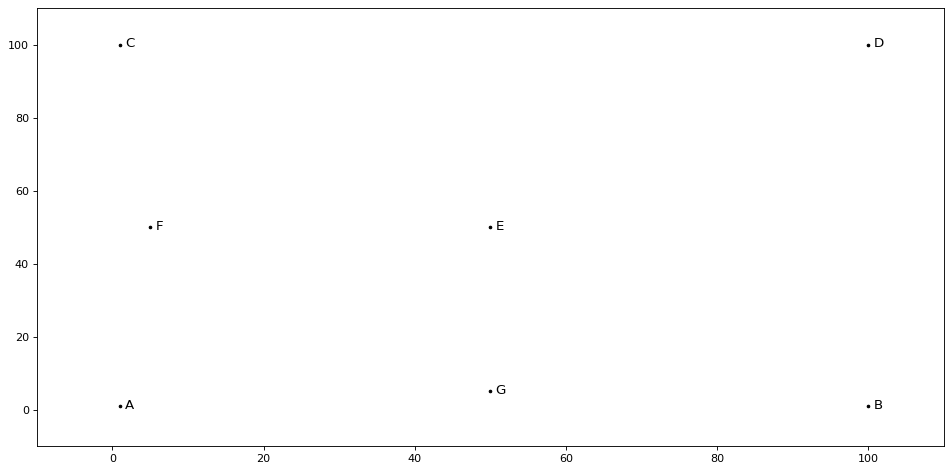


## Matriz de Distancias: 
           A        B        C        D       E        F        G
  A    0.000   99.000   99.000  140.007  69.296   49.163   49.163
  B   99.000    0.000  140.007   99.000  70.007  106.892   50.160
  C   99.000  140.007    0.000   99.000  70.007   50.160  106.892
  D  140.007   99.000   99.000    0.000  70.711  107.355  107.355
  E   69.296   70.007   70.007   70.711   0.000   45.000   45.000
  F   49.163  106.892   50.160  107.355  45.000    0.000   63.640
  G   49.163   50.160  106.892  107.355  45.000   63.640    0.000

 - Distancia promedio:  83.0  --> Total promedio:  579.0




In [ ]:
#@title clase MAPA DE BÚSQUEDA TSP

class MapaBusquedaTSP(object):

    def __init__(self, limMin=-100, limMax=100, posiciones=[], cantPosiciones=10):
          self.limMin = limMin
          self.limMax = limMax
          if (posiciones is None) or (len(posiciones) < 2):
            # genera posiciones al azar
            if cantPosiciones > 2:
              self.cantidadPosiciones = cantPosiciones
            else:
              self.cantidadPosiciones = 2
            self.generarPosicionesRnd( self.cantidadPosiciones)
          else:
            # usa las posiciones indicadas
            self.posiciones = copy.deepcopy(posiciones)
            self.cantidadPosiciones = len(self.posiciones)
          # calcula la matriz de distancia
          self.matrizDistancia = spatial.distance.cdist(self.posiciones, self.posiciones, metric='euclidean')
          self.maxDistanciaPenalizar = np.max(  self.matrizDistancia ) + 1

    def generarPosicionesRnd(self, cantPosiciones):
        # Define las posiciones al azar
        self.posiciones = []
        for i in range(cantPosiciones):
          auxPos = [ random.randint(self.limMin, self.limMax),  random.randint(self.limMin, self.limMax) ]
          self.posiciones.append( auxPos )
        return True

    def formateaIdPosicion(self, idPos):
        return chr(idPos+65)

    def formateaListaPosiciones(self, posList):
      auxRes = "[ "
      for id in posList:
        auxRes = auxRes + self.formateaIdPosicion(id) + " - "
      auxRes = auxRes[:len(auxRes)-2] + "]"
      return auxRes

    def mostrarMatriz(self, matriz, titulo=""):
        print("\n"+titulo)
        cmd = pd.DataFrame(
            np.round(matriz, decimals=3),
            index=["  "+self.formateaIdPosicion(x) for x in range(self.cantidadPosiciones)],
            columns=[self.formateaIdPosicion(x) for x in range(self.cantidadPosiciones)]
          )
        # agrega para poder mostrar la matrix completa
        pd.options.display.max_rows = 100
        pd.options.display.max_columns = 100
        print(cmd)
        return

    def printInformacion(self):
        # Muestra la información sobre el Mapa de Búsqueda

        ## muesta las posiciones generadas
        print("\n## Posiciones generadas: ", self.cantidadPosiciones)
        i = 0
        for auxPos in self.posiciones:
            print("  ", self.formateaIdPosicion(i),"-->", auxPos)
            i = i + 1
        # muestra gráfico con
        self.graficar(True)

        # muestra la matriz de distancia
        self.mostrarMatriz(self.matrizDistancia, "## Matriz de Distancias: ")
        # calcula distancia promedio
        filter_arr = self.matrizDistancia > 0
        distAvg = np.mean( self.matrizDistancia[filter_arr] )
        print("\n - Distancia promedio: ", round(distAvg, 0), " --> Total promedio: ", round(distAvg*self.cantidadPosiciones, 0))
        print("\n")
        return

    # Definir posiciones de un recorrido
    def devPosicionesRecorrido(self, recorrido, agregaPrimeroFinal=True):
      # determina el recorrido
      coordX = []
      coordY = []
      for r in recorrido:
        pos = self.posiciones[r]
        coordX.append( pos[0] )
        coordY.append( pos[1] )
      if agregaPrimeroFinal:
        # agrega al final la posición original para que cierre el circuito
        pos = self.posiciones[ recorrido[0] ]
        coordX.append( pos[0] )
        coordY.append( pos[1] )
      return coordX, coordY

    def graficar(self, mostrar=True):
      fig = plt.figure(figsize=(12,6), dpi=80)
      ax = fig.add_subplot(111)
      ax.axis([self.limMin-10, self.limMax+10, self.limMin-10, self.limMax+10])
      # muesta posiciones en el gráfico
      i = 0
      for auxPos in self.posiciones:
          ax.scatter(auxPos[0], auxPos[1], color="black", s=5)
          ax.annotate(self.formateaIdPosicion(i), (auxPos[0]+0.7, auxPos[1]-0.7), fontsize=12)
          i = i + 1
      if mostrar:
        plt.tight_layout()
        plt.show()
      return fig, ax

    def calculaDistanciaTotal(self, routine):
        num_points = len(routine)
        return sum([self.matrizDistancia[routine[i % num_points], routine[(i + 1) % num_points]] for i in range(num_points)])

print("\nClase Mapa de Búqueda definida TSP")

# Define el Mapa de Búsqueda
mapa = MapaBusquedaTSP(limMin=MIN_ESPACIO_BUSQ, limMax=MAX_ESPACIO_BUSQ, \
                    posiciones=posDefinidas,
                    cantPosiciones=CANT_POSICIONES)

print("\nMapa de búsqueda TSP definido")

# Muestra su información
mapa.printInformacion()

In [ ]:
#@title FUNCIÓN DE APTITUD Y ESTRUCTURA DEL CROMOSOMA

#@markdown > Función de Aptitud:
#@markdown - indica que es para minimizar.
#@markdown - determina la aptitud como la suma de las distancias a ser recorridas para unir todos los puntos.
#@markdown   Pero, también penaliza si quedan puntos repetidos y/o puntos por los que no pasa.

## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()

# indica que es la función de aptitud es para maximizar
creator.create("Fitness", base.Fitness, weights=(-1.0,))

# definimos la función de aptitud
def funcAptitud(individual):
    # calcula la distancia total del recorrido
    res = mapa.calculaDistanciaTotal(individual)
    # penaliza si hay puntos por los que no pasa
    # y/o si hay puntos pasa más de una vez
    for i in range(mapa.cantidadPosiciones):
      cantI = individual.count(i) - 1
      if cantI < 0:
        # penaliza por falta punto
        res = res + mapa.maxDistanciaPenalizar
      elif cantI > 0:
        # penaliza por cada ocurrencia repetida
        res = res + mapa.maxDistanciaPenalizar * cantI
    return res,

# registra la función que se va a evaluar
toolbox.register("evaluate", funcAptitud)

print("\nFunción de Aptitud definida")


#@markdown > Estructura del Cromosoma:
#@markdown - indica que es una lista de valores enteros que indican los IDs de los puntos a ser recorridos.
inicializar_individuos = 'Azar' #@param ["Azar", "Espacial-Lista"]

valorMax_genesCromosomas = mapa.cantidadPosiciones - 1
cant_genesCromosoma = mapa.cantidadPosiciones
FINALIZA_CORRIDA_VAL_MIN_APTITUD = FINALIZA_CORRIDA_POR_APTITUD

# indica que los individuos son una lista de genes que aplica la función antes definida
creator.create("Individual", list, fitness=creator.Fitness)

# indica que los genes son enteros
if inicializar_individuos == 'Azar':
  # registra el tipo de individuo como lista valores al azar (puede haver repetidos y faltantes)
  toolbox.register("puntos", random.randint, 0, valorMax_genesCromosomas)
  toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.puntos, cant_genesCromosoma)
else:
  # registra el tipo de individuo como una permutación de posibles puntos
  # (así siempre tiende a generar combinaciones válidas, sin repetidos ni faltantes)
  toolbox.register("puntos", random.sample, range(mapa.cantidadPosiciones), mapa.cantidadPosiciones)
  toolbox.register("individual", tools.initIterate, creator.Individual,toolbox.puntos)

# registra la población a usar
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Determina mínima Heuristica para finalizar el algoritmo
MIN_HEURISTICA_FINALIZAR = mapa.cantidadPosiciones * 1

print("\nCromosoma definido")


Función de Aptitud definida

Cromosoma definido


In [ ]:
#@title OPERADORES GENÉTICOS
#@markdown definidos  en https://deap.readthedocs.io/en/master/api/tools.html#operators

tipo_seleccion = 'Torneo' #@param ["Azar", "Torneo", "Ranking", "Ruleta"]
tipo_cruzamiento = 'Simple-1Punto' #@param ["Simple-1Punto", "Simple-2Puntos", "Azar", "Especial-Lista"]
tipo_mutacion = 'Simple' #@param ["Simple", "Especial-Lista"]

# Probabilidad del Mutación
probab_mutacion = 0.35 #@param {type:"slider", min:0, max:1, step:0.05}

# Registrar tipo de Selección a aplicar con sus parámetros
if tipo_seleccion == 'Torneo':
  toolbox.register("select", tools.selTournament, tournsize=2)
elif tipo_seleccion == 'Ranking':
  toolbox.register("select", tools.selBest)
elif tipo_seleccion == 'Ruleta':
  toolbox.register("select", tools.selRoulette)
else:
  toolbox.register("select", tools.selRandom)

# Registrar tipo de Cruzamiento a aplicar con sus parámetros
if tipo_cruzamiento == 'Simple-1Punto':
  toolbox.register("mate", tools.cxOnePoint)
elif tipo_cruzamiento == 'Simple-2Puntos':
  toolbox.register("mate",  tools.cxTwoPoint)
elif tipo_cruzamiento == "Azar":
  toolbox.register("mate", tools.cxUniform, indpb=1/cant_genesCromosoma)
else:
  # como es una lista de puntos ya conocida, usa otro método de cruzamiento
  toolbox.register("mate", tools.cxOrdered)

# Registrar tipo de Mutación a aplicar con sus parámetros
if tipo_mutacion == "Simple":
  toolbox.register("mutate", tools.mutUniformInt, low=0, up=valorMax_genesCromosomas, indpb=1/cant_genesCromosoma)
else:
  # como es una lista de puntos ya conocida, usa otro método de mutación
  toolbox.register("mutate", tools.mutShuffleIndexes, indpb=1/cant_genesCromosoma)

print("\nOperadores Genéticos definidos")


Operadores Genéticos definidos


4) Ejecutar la corrida del algoritmo mostrando resultados:

In [ ]:
#@title FUNCIONES AUXILIARES

## Define una función auxiliar para calcular estadísticas y guarda info en vectores auxiliares
def CalculoEstadisticas(ciclo, indivPobla, muestra, mejorMax = True):
    global mejorIndCorrida, mejorIndCorrida_ciclo
    global ciclosMaxAptitud
    global ciclosPromAptitud
    global ciclosMinAptitud
    if len(indivPobla) == 0:
      return None, 0, 0, 0
    auxMax = None
    auxMin = None
    auxSum = 0
    auxBestInd = None
    auxBestIndApt = None
    for ind in indivPobla:
        apt = round(ind.fitness.values[0], 2)
        auxSum = auxSum + apt
        if (auxMax == None) or (apt > auxMax):
            auxMax = apt
            if mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt
        if (auxMin == None) or (apt < auxMin):
            auxMin = apt
            if not mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt
    auxProm = round(auxSum / len(indivPobla), 2)
    if (mejorIndCorrida == None) or (mejorIndCorrida.fitness.values > auxBestInd.fitness.values):
          mejorIndCorrida = auxBestInd
          mejorIndCorrida_ciclo = ciclo
    ciclosMaxAptitud.append( auxMax )
    ciclosPromAptitud.append( auxProm )
    ciclosMinAptitud.append( auxMin )
    if muestra:
        #print("\n-- Ciclo  %i --" % ciclo)
        print(" ++ Mejor Individuo:", mapa.formateaListaPosiciones(auxBestInd), " {", round(auxBestIndApt, 3), "}")
        print("      Max: ", auxMax, " / Promedio: ", auxProm, " / Min: ", auxMin)
    return auxBestInd, auxMax, auxProm, auxMin

def asignarAptitud(indivPobla):
  # Asigna el valor de aptitud a los individuos
  fitnesses = list(map(toolbox.evaluate, indivPobla))
  for ind, fit in zip(indivPobla, fitnesses):
      ind.fitness.values = fit


def mostrarParamsDetalle():
  print("EJECUCIÓN DE LA CORRIDA: ")
  print("\t Criterio de Paro: "+str(CANT_CICLOS)+" ciclos"+(", o si llega a la solución" if FINALIZA_CORRIDA_POR_APTITUD else "")+".")
  print("\t Tamaño de la Población: "+str(CANT_INDIVIDUOS_POBLACION)+" individuos.")
  print("\t Método de Selección: "+tipo_seleccion+".")
  print("\t Método de Cruzamiento: "+tipo_cruzamiento+".")
  print("\t Método de Mutación: Simple con "+str(probab_mutacion*100)+"% de probabilidad.")
  print("")

def mostrarPoblaDetalle(indivPobla, titulo=""):
  if titulo != "":
    print("\n" + titulo)
  for ind in indivPobla:
    print("\t", mapa.formateaListaPosiciones(ind), " { ", round(ind.fitness.values[0], 3), " } ")
  print("")

print("\nFunciones auxiliares definidas")


Funciones auxiliares definidas


EJECUCIÓN DE LA CORRIDA: 
	 Criterio de Paro: 50 ciclos, o si llega a la solución.
	 Tamaño de la Población: 15 individuos.
	 Método de Selección: Torneo.
	 Método de Cruzamiento: Simple-1Punto.
	 Método de Mutación: Simple con 35.0% de probabilidad.


-- Ciclo  0 --

*) Población Inicial:
	 [ G - F - C - F - A - B - C ]  {  1123.05  } 
	 [ E - F - D - G - A - C - F ]  {  785.046  } 
	 [ C - G - C - G - D - F - A ]  {  1247.578  } 
	 [ F - B - A - A - G - A - A ]  {  1199.424  } 
	 [ B - G - F - G - E - B - A ]  {  1054.475  } 
	 [ B - E - C - E - E - B - C ]  {  1688.1  } 
	 [ B - C - A - F - G - C - G ]  {  1179.783  } 
	 [ B - A - B - C - A - B - A ]  {  1862.064  } 
	 [ G - G - C - B - F - A - F ]  {  1079.786  } 
	 [ F - E - A - C - A - D - C ]  {  1165.492  } 
	 [ C - D - D - C - E - F - B ]  {  1123.935  } 
	 [ D - E - C - C - E - C - F ]  {  1284.289  } 
	 [ D - G - A - C - C - G - D ]  {  1315.807  } 
	 [ A - F - A - D - C - E - B ]  {  858.362  } 
	 [ C - A - E - E - D - C - 

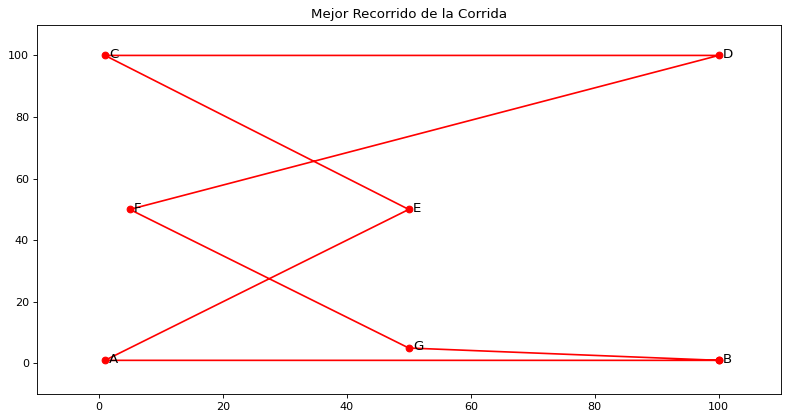

== Mejor Individuo de la Corrida aparece en ciclo 4:[ B - G - F - D - C - E - A ] { 558.458 }  == 



In [ ]:
#@title EJECUCIÓN DE LA CORRIDA

# Indica si se muestra el detalle de los operadores genéticos aplicados
MOSTRAR_DETALLE = True #@param {type:"boolean"}

# Indica si se muestra el detalle de las estadísticas en cada ciclo
MUESTRA_ESTADISTICAS = True  #@param {type:"boolean"}

if MOSTRAR_DETALLE:
  mostrarParamsDetalle()

# Resetear Genelogy
history = tools.History()
# Decorate the variation operators
toolbox.decorate("mate", history.decorator)
toolbox.decorate("mutate", history.decorator)

# cálcula cantidad de individuos seleccionados como la mitad + 1
cant_ind_selecc = (CANT_INDIVIDUOS_POBLACION//2)+1

# Define la población inicial
indivPobla = toolbox.population(n=CANT_INDIVIDUOS_POBLACION)
history.update(indivPobla)

# Asigna el valor de aptitud a los individuos de la población inicial
asignarAptitud(indivPobla)

if MOSTRAR_DETALLE or MUESTRA_ESTADISTICAS:
  print("\n-- Ciclo  0 --")

if MOSTRAR_DETALLE:
  mostrarPoblaDetalle(indivPobla, "*) Población Inicial:")

# vectores auxiliares
ciclo = 1
mejorIndCorrida = None
mejorIndCorrida_ciclo = 0
ciclosIndiv = []
ciclosMaxAptitud = []
ciclosPromAptitud = []
ciclosMinAptitud = []


# Cálcula estadísticas y guarda info en vectores auxiliares
auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(0, indivPobla, MUESTRA_ESTADISTICAS, mejorMax=False)
ciclosIndiv.append( auxBestInd )

        # criterio de paro
while (ciclo < CANT_CICLOS) \
  and (not(FINALIZA_CORRIDA_POR_APTITUD) or (mejorIndCorrida==None) or (mejorIndCorrida.fitness.values[0] > MIN_HEURISTICA_FINALIZAR)):

    if MOSTRAR_DETALLE or MUESTRA_ESTADISTICAS:
      print("\n-- Ciclo  %i --" % ciclo)

    # Realiza la Selección
    indivSelecc = toolbox.select(indivPobla, cant_ind_selecc)
    if MOSTRAR_DETALLE:
      mostrarPoblaDetalle(indivSelecc, "a) Individuos Seleccionados:")

    # Realiza el Cruzamiento
    # por cada individuo seleccionado los clona (sino pueden afectarle los cambios)
    # y luego le busca una pareja al azar dentro de los seleccionados para generar 2 hijos
    if MOSTRAR_DETALLE:
      print("b) Cruzamiento: ")
    indivHijos = []
    for hijo1 in list(map(toolbox.clone, indivSelecc)):
      if len(indivHijos) < len(indivPobla):
        # todavía falta generar hijos
        hijo2 = list(map(toolbox.clone, random.sample(indivSelecc, 1)))[0]
        if MOSTRAR_DETALLE:
          print("\t", mapa.formateaListaPosiciones(hijo1), "x", mapa.formateaListaPosiciones(hijo2), end=" =")
        # hace el cruzamiento
        toolbox.mate(hijo1, hijo2)
        del hijo1.fitness.values
        del hijo2.fitness.values
        # agrega 1er hijo
        indivHijos.append(hijo1)
        if MOSTRAR_DETALLE:
          print("", mapa.formateaListaPosiciones(hijo1), end="")
        if len(indivHijos) < len(indivPobla):
          # agrega 2do hijo
          indivHijos.append(hijo2)
          if MOSTRAR_DETALLE:
            print(" &", mapa.formateaListaPosiciones(hijo2), end="")
        if MOSTRAR_DETALLE:
          print("")
      else:
        break

    # controla que mantenga que los hijos
    # tenga la misma cantidad de individuos que la población original
    if len(indivHijos) != len(indivPobla):
      print("ERROR: distinta cantidad de individuos hijos ", len(indivHijos) , " | ", len(indivPobla))

    # Realiza la Mutación
    if MOSTRAR_DETALLE:
      print("\nc) Mutación: ")
    if random.random() < probab_mutacion:
      # ejecuta mutación:
      # selecciona al azar el individuo a mutar
      # y lo muta aplicando el método
      mutant = indivHijos[random.randint(0, len(indivHijos)-1)]
      if MOSTRAR_DETALLE:
        print("\tse ejecuta: ", mapa.formateaListaPosiciones(mutant), end=" ")
      # hace la mutación
      toolbox.mutate(mutant)
      del mutant.fitness.values
      if MOSTRAR_DETALLE:
        print("--> ", mapa.formateaListaPosiciones(mutant), "\n")
    else:
      # no se ejecuta mutación
      print("\tNo se ejecuta\n")

    # Evalua a los individuos hijos que salen de Cruzamiento & Mutación
    #  para determinar si son válidos y su valor de aptitud
    invalid_ind = [ind for ind in indivHijos if not ind.fitness.valid]
    asignarAptitud(invalid_ind)

    # Reemplaza la población actual con los hijos
    indivPobla[:] = indivHijos
    if MOSTRAR_DETALLE:
      mostrarPoblaDetalle(indivPobla, "*) Siguiente Generación:")

    # Cálcula estadísticas y guarda info en vectores auxiliares
    auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(ciclo, indivPobla, MUESTRA_ESTADISTICAS, mejorMax=False)
    ciclosIndiv.append( auxBestInd )

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --" % ciclo )
msgMejor = "== Mejor Individuo de la Corrida aparece en ciclo " + str(mejorIndCorrida_ciclo) + ":" + mapa.formateaListaPosiciones(mejorIndCorrida) + " { " + str(round(mejorIndCorrida.fitness.values[0], 3)) + " }  =="
print(msgMejor, "\n")


# Muesta el gráfico del Mejor Recorrido
fig, ax = mapa.graficar(mostrar=False)
# determina el recorrido
# Determina las coordenadas x, y de las posiciones en el mejor recorrido
X, Y = mapa.devPosicionesRecorrido( mejorIndCorrida )
# muesta el recorrido
ax.plot(X, Y, 'o-r')
ax.set_title("Mejor Recorrido de la Corrida")
#plt.tight_layout()
plt.show()
print(msgMejor, "\n")

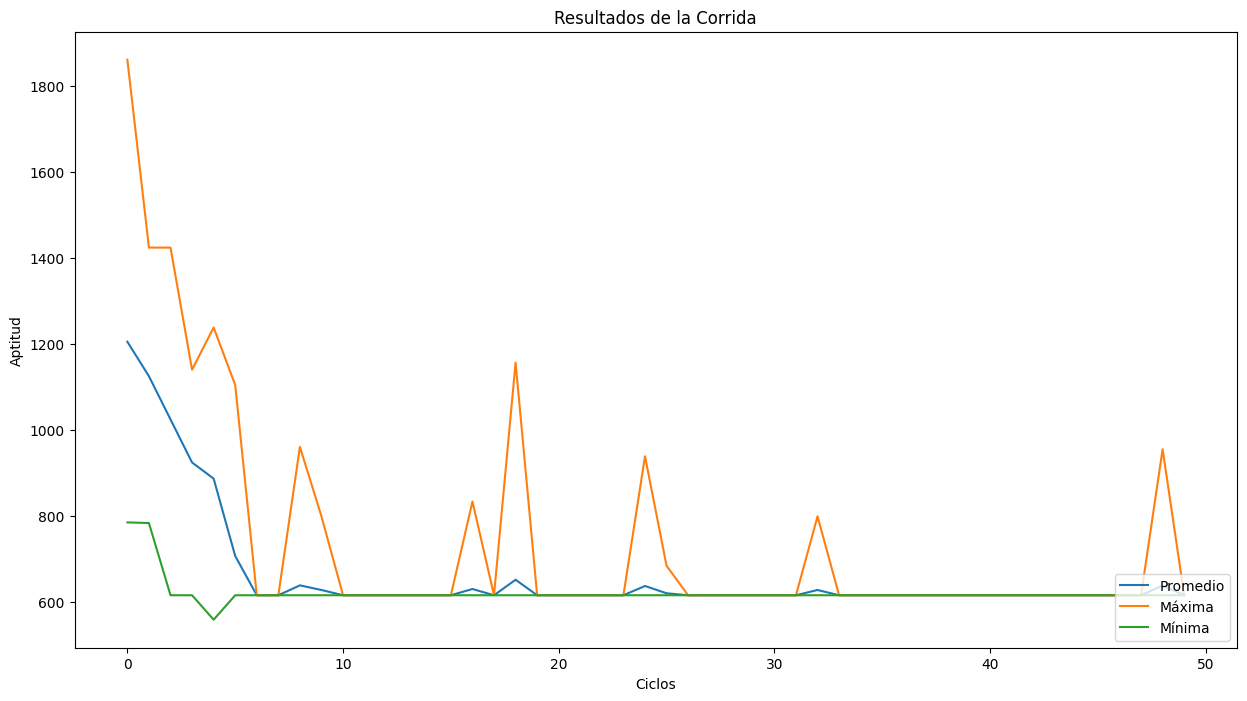

In [ ]:
#@title MOSTRAR GRÁFICO DE LA CORRIDA
plt.figure(figsize=(15,8))
plt.plot(ciclosPromAptitud)
plt.plot(ciclosMaxAptitud)
plt.plot(ciclosMinAptitud)

plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Aptitud')
plt.legend(['Promedio', 'Máxima', 'Mínima'], loc='lower right')

plt.show()

In [ ]:
#@title MOSTRAR GRAFICO MEJOR RECORRIDO POR CADA CICLO

# Librerías especiales para usar
from matplotlib import animation, rc
from IPython.display import HTML

# inicializa variables auxiliares
recCiclo = ciclosIndiv
distCiclo = ciclosMinAptitud

# Método que se ejecuta por cada frame para mostrar
def updatePlot(i):
    i = i - 1 # le resta 1 para que arranque vacío
    if i < 0:
        axRec.set_xlabel(" ", fontsize=12)
    else:
      if i<len(recCiclo):
        distMostrar = str(round(distCiclo[i], 3))
        if i == mejorIndCorrida_ciclo:
          distMostrar = distMostrar + "!"
          colorLineRec = 'r'
        else:
          colorLineRec = 'c'
        axRec.set_xlabel("Ciclo: " + str(i) + " - Distancia Recorrido: " + distMostrar, fontsize=12)
        # Determina las coordenadas x, y del recorrido 'i'
        X, Y = mapa.devPosicionesRecorrido( recCiclo[i] )
        plt.setp(lineRec, 'xdata', X, 'ydata', Y)
        plt.setp(lineRec, 'color', colorLineRec)
      else:
        axRec.set_xlabel("Ciclo: " + str(i), fontsize=12)
    return lineRec

# prepara gráfico para animación
fig, axRec = mapa.graficar(mostrar=False)
axRec.set_xticklabels([])
plt.close(fig)

# Determina las coordenadas x, y de las posiciones en el recorrido inicial
# (las marca en blanco para que no se vean)
X, Y = mapa.devPosicionesRecorrido( recCiclo[0] )
lineRec = axRec.plot(X, Y,
            marker='o', markerfacecolor='b', color='w', linestyle='-')
lineFer = []
# Muestra título y texto debajo
axRec.set_title("Mejor Recorrido por Ciclo")

# Luego setea la animación usando los dos métodos anteriores
cant = len(recCiclo)+1  # le suma 1 porque arranca vacío
ani = animation.FuncAnimation(fig, updatePlot,
                              frames=cant, interval=cant,
                              blit=True, repeat=False)

# Nota: esto se agega para que funcione en Google Colab
rc('animation', html='jshtml')
display(ani)

print("\n", msgMejor)


 == Mejor Individuo de la Corrida aparece en ciclo 4:[ B - G - F - D - C - E - A ] { 558.458 }  ==
